In [10]:
from pathlib import Path
import numpy as np
from tqdm import tqdm

import sys
sys.path.append('../src/')
from emg import (
    read_mat, pick_key, ensure_samples_channels,
    bandpass_filter, rectify_and_zscore, sliding_window,
    subject_id_from_path
)

# project paths
ROOT = Path("..")
DATA_RAW       = ROOT / "data" / "ninapro" / "db1" / "raw"
DATA_PROCESSED = ROOT / "data" / "processed" / "db1"
DATA_OUTPUTS   = ROOT / "data" / "outputs"   / "db1"
for p in [DATA_PROCESSED, DATA_OUTPUTS]:
    p.mkdir(parents=True, exist_ok=True)

print("RAW:", DATA_RAW)

RAW: ../data/ninapro/db1/raw


In [11]:
# Ninapro DB1 parameters
FS = 100.0  # Hz (DB1 envelope sampling rate)

# Windowing for deep learning inputs
WINDOW_S   = 0.5   # 0.5s → 50 samples
STEP_S     = 0.1   # hop
MIN_FRAC   = 0.7   # label purity within a window (drop mixed windows)
DROP_REST  = True  # drop label 0 windows

# Optional: constrain to a subset of exercises/classes to start simple
FILTER_MIN_SAMPLES_PER_CLASS = 1000  # drop rare classes after windowing; set None to disable

# Subject split: pick held-out test subjects (by ID parsed from filenames S{ID}_...)
TEST_SUBJECT_COUNT = 5  # keep 2 subjects for test; rest for train/val

np.random.seed(0)

In [12]:
mats = sorted(DATA_RAW.rglob("*.mat"))
print(f"Found .mat files: {len(mats)}")
assert mats, "No .mat files found under data/raw/ninapro/db1"
mats[:5]

Found .mat files: 81


[PosixPath('../data/ninapro/db1/raw/s1/S1_A1_E1.mat'),
 PosixPath('../data/ninapro/db1/raw/s1/S1_A1_E2.mat'),
 PosixPath('../data/ninapro/db1/raw/s1/S1_A1_E3.mat'),
 PosixPath('../data/ninapro/db1/raw/s10/S10_A1_E1.mat'),
 PosixPath('../data/ninapro/db1/raw/s10/S10_A1_E2.mat')]

In [13]:
import numpy as np

def sliding_window_pure(x, y, *, window_s, step_s, fs, min_frac=0.7):
    win, step = int(window_s * fs), int(step_s * fs)
    Xw, Yw = [], []
    for start in range(0, len(x) - win + 1, step):
        seg = x[start:start + win]
        lab = y[start:start + win]

        vals, counts = np.unique(lab, return_counts=True)
        nonzero_mask = (vals != 0)
        if not np.any(nonzero_mask):
            # window is all rest
            maj_lab, frac = 0, counts.max() / win
        else:
            vals_nz, counts_nz = vals[nonzero_mask], counts[nonzero_mask]
            maj_idx = np.argmax(counts_nz)
            maj_lab = vals_nz[maj_idx]
            frac = counts_nz[maj_idx] / win

        if frac < min_frac:
            continue

        Xw.append(seg)
        Yw.append(maj_lab)
    Xw = np.stack(Xw) if Xw else np.empty((0, win, x.shape[1]), dtype=np.float32)
    Yw = np.array(Yw, dtype=np.int32)
    return Xw, Yw

In [14]:
X_list, y_list, subj_list = [], [], []

for p in tqdm(mats, desc="Windowing"):
    d   = read_mat(p)
    emg = ensure_samples_channels(pick_key(d, "emg"))
    lab = np.asarray(pick_key(d, "restimulus"), dtype=np.int32)

    # Preprocess for DL: bandpass + zscore (keep as raw-ish normalized sequences)
    x_p = rectify_and_zscore(bandpass_filter(emg, fs=FS, low=1.0, high=40.0))

    # Window with label purity
    Xw, Yw = sliding_window_pure(x_p, lab, window_s=WINDOW_S, step_s=STEP_S, fs=FS, min_frac=MIN_FRAC)
    if Xw.shape[0] == 0:
        continue

    sid = subject_id_from_path(p)
    X_list.append(Xw)
    y_list.append(Yw)
    subj_list.append(np.full(len(Yw), sid, dtype=np.int32))

# Concatenate across files
X_raw = np.concatenate(X_list, axis=0) if X_list else np.empty((0,))
y     = np.concatenate(y_list, axis=0) if y_list else np.empty((0,), dtype=np.int32)
subj  = np.concatenate(subj_list, axis=0) if subj_list else np.empty((0,), dtype=np.int32)

print("Raw windows:", X_raw.shape, "labels:", y.shape, "subjects:", subj.shape)

Windowing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:22<00:00,  3.52it/s]


Raw windows: (1159472, 50, 10) labels: (1159472,) subjects: (1159472,)


# Optionally drop rest & rare classes

In [15]:
mask = np.ones_like(y, dtype=bool)
if DROP_REST:
    mask &= (y != 0)

Xr, yr, subjr = X_raw[mask], y[mask], subj[mask]

if FILTER_MIN_SAMPLES_PER_CLASS is not None:
    vals, counts = np.unique(yr, return_counts=True)
    keep_classes = set(vals[counts >= FILTER_MIN_SAMPLES_PER_CLASS])
    keep_mask = np.isin(yr, list(keep_classes))
    Xr, yr, subjr = Xr[keep_mask], yr[keep_mask], subjr[keep_mask]

print("After filtering:", Xr.shape, yr.shape, np.unique(yr).size, "classes")

After filtering: (499555, 50, 10) (499555,) 23 classes


In [16]:
unique_subj = sorted(np.unique(subjr))
# hold out last TEST_SUBJECT_COUNT subjects
test_subj = set(unique_subj[-TEST_SUBJECT_COUNT:])
trainval_subj = [s for s in unique_subj if s not in test_subj]

print("Test subjects:", sorted(test_subj))
print("Train/Val subjects:", trainval_subj[:10], "… total:", len(trainval_subj))

# split train/val by subject too (e.g., 80/20 of the remaining subjects)
split = max(1, int(0.8 * len(trainval_subj)))
train_subj = set(trainval_subj[:split])
val_subj   = set(trainval_subj[split:])

print("Train subjects:", sorted(train_subj))
print("Val subjects:", sorted(val_subj))

tr_idx = np.isin(subjr, list(train_subj))
va_idx = np.isin(subjr, list(val_subj))
te_idx = np.isin(subjr, list(test_subj))

X_train, y_train, s_train = Xr[tr_idx], yr[tr_idx], subjr[tr_idx]
X_val,   y_val,   s_val   = Xr[va_idx], yr[va_idx], subjr[va_idx]
X_test,  y_test,  s_test  = Xr[te_idx], yr[te_idx], subjr[te_idx]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Test subjects: [np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27)]
Train/Val subjects: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10)] … total: 22
Train subjects: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17)]
Val subjects: [np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22)]
Train: (312643, 50, 10) Val: (93436, 50, 10) Test: (93476, 50, 10)


In [17]:
# remap labels to 0..K-1 for NN convenience
classes = sorted(np.unique(y_train))  # train classes define the map
label_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_label = np.array(classes, dtype=np.int32)

def remap(yv):
    return np.vectorize(label_to_idx.get)(yv)

y_train_m = remap(y_train)
y_val_m   = remap(y_val)
y_test_m  = remap(y_test)

print("Classes (original → idx) sample:", list(label_to_idx.items())[:10])
print("N classes:", len(classes))

# save everything in NPZs (channel-first or channel-last? We'll keep time-first for now: (T,C))
np.savez_compressed(DATA_PROCESSED / "dl_train_db1_raw.npz",
                    X=X_train.astype(np.float32), y=y_train_m.astype(np.int64), subj=s_train.astype(np.int32),
                    idx_to_label=idx_to_label)
np.savez_compressed(DATA_PROCESSED / "dl_val_db1_raw.npz",
                    X=X_val.astype(np.float32), y=y_val_m.astype(np.int64), subj=s_val.astype(np.int32),
                    idx_to_label=idx_to_label)
np.savez_compressed(DATA_PROCESSED / "dl_test_db1_raw.npz",
                    X=X_test.astype(np.float32), y=y_test_m.astype(np.int64), subj=s_test.astype(np.int32),
                    idx_to_label=idx_to_label)

print("Saved npz files to:", DATA_PROCESSED)

Classes (original → idx) sample: [(np.int32(1), 0), (np.int32(2), 1), (np.int32(3), 2), (np.int32(4), 3), (np.int32(5), 4), (np.int32(6), 5), (np.int32(7), 6), (np.int32(8), 7), (np.int32(9), 8), (np.int32(10), 9)]
N classes: 23
Saved npz files to: ../data/processed/db1


Train classes: (23, [(0, 18155), (1, 17564), (2, 18053), (3, 17026), (4, 17113), (5, 17362), (6, 17700), (7, 18155), (8, 17496), (9, 17478)])
Val   classes: (23, [(0, 5327), (1, 5488), (2, 5370), (3, 5263), (4, 5212), (5, 5291), (6, 5353), (7, 5169), (8, 5085), (9, 5010)])
Test  classes: (23, [(0, 5344), (1, 5323), (2, 5765), (3, 5254), (4, 4936), (5, 5062), (6, 5243), (7, 5466), (8, 5677), (9, 5050)])


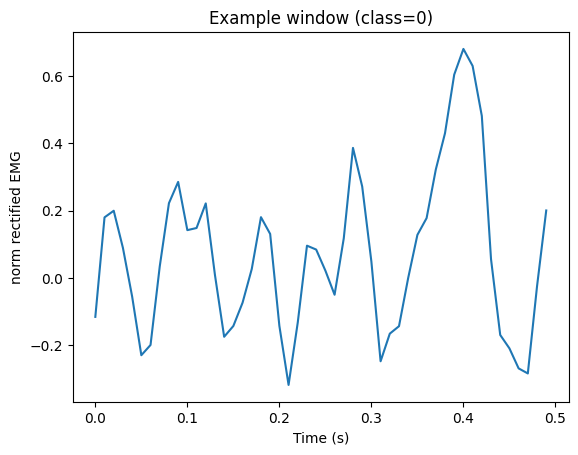

In [18]:
import collections
def dist(y):
    cnt = collections.Counter(y.tolist())
    return len(cnt), sorted(cnt.items())[:10]

print("Train classes:", dist(y_train_m))
print("Val   classes:", dist(y_val_m))
print("Test  classes:", dist(y_test_m))

# peek one window
import matplotlib.pyplot as plt
if X_train.shape[0] > 0:
    t = np.arange(X_train.shape[1]) / FS
    ch = 0
    plt.plot(t, X_train[0, :, ch])
    plt.title(f"Example window (class={y_train_m[0]})")
    plt.xlabel("Time (s)"); plt.ylabel("norm rectified EMG")
    plt.show()